<a href="https://colab.research.google.com/github/CAPost0110/Credit_Card_Fraud_Project-03_23-/blob/main/Portfolio_Project_Credit_Card_Fraud_bk2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook number 2 for the project (3.14.23)

### Notebook one was highly experimental and...broad.  This notebook will build off of the findings from the previous and probably lead to a 3rd notebook to be honest 😆 but it will be more focused than the previous!

Some of the things focused on in this notebook:
- SweetViz 
  - A new/different way to do EDA
- AutoClean
  - I found and experimented with this module and though it takes 30mins to run, I think it is clea...better than winsorizing each column separately
- LazyClassifier
  - I was asked to run LazyClassifier yesterday but didn't have the time it took to run it (randomforest takes forever!!)
  - I'll start it again here and check to see if there are ways to remove some of the algos, as well as turn on verbose so that I can better see what is taking so long
- Comparison
  - The end goal is a comparison visual of all the models. A simple DataFrame would suffice, but I'm sure there's something even better 😏

In [ ]:
# Some of our libraries need to be installed
!pip install dabl
!pip install -U imbalanced-learn
!pip install py-AutoClean
!pip install loguru
!pip install lazypredict
!pip install sweetviz

In [2]:
# Imports
# basics
import pandas as pd
import numpy as np

# prep
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder # shouldn't need thanks to AutoClean
from sklearn.decomposition import PCA
from AutoClean import AutoClean

# measure
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, classification_report

# importing machine learning models for prediction
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.neural_network import MLPRegressor

from keras.utils import np_utils

# importing voting classifier
from sklearn.ensemble import VotingClassifier, VotingRegressor # Maybe not worth using this time
from lazypredict.Supervised import LazyClassifier, LazyRegressor
#from sklearn import datasets

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
import dabl 
from mpl_toolkits.mplot3d import Axes3D
import sweetviz as sw



In [4]:
# The data
data = pd.read_csv('/content/drive/MyDrive/Data Science/Data Science Data/creditcard.csv')

## Data Exploration

This time I will utilize sweetviz for our data exploration

In [8]:
analyze_report = sw.analyze(data)
analyze_report.show_html('output.html', open_browser=True)

                                             |          | [  0%]   00:00 -> (? left)

Report output.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## This creates an html visual which is very informative! 

https://medium.com/@fareedkhandev/exploratory-data-analysis-eda-in-a-single-line-of-code-d3a2b202f3e4

We can see:

- feature importance
  - based on the correlation matrix visual we can slim down the features from 30 to under 10. As such, this time we will not use PCA, but try dropping all but the top important features as identified by these visuals
- all descriptive statistics per feature
  - including kurtosis and skew!


**** One thing to note is that neither sweetviz or AutoClean seem to catch the data imbalance we have.  Before moving forward, I will perform oversampling...

In [19]:
# create working DF based on insights derived from Sweet viz
df = data.loc[:, ['V3','V4','V7','V10','V11','V12','V14','V16','V17','Class']]
df.head()

,V3,V4,V7,V10,V11,V12,V14,V16,V17,Class
0,2.54,1.38,0.24,0.09,-0.55,-0.62,-0.31,-0.47,0.21,0
1,0.17,0.45,-0.08,-0.17,1.61,1.07,-0.14,0.46,-0.11,0
2,1.77,0.38,0.79,0.21,0.62,0.07,-0.17,-2.89,1.11,0
3,1.79,-0.86,0.24,-0.05,-0.23,0.18,-0.29,-1.06,-0.68,0
4,1.55,0.40,0.59,0.75,-0.82,0.54,-1.12,-0.45,-0.24,0


In [85]:
df.drop_duplicates(keep='first', inplace=True)

In [86]:
# X/y Split 
X = df.loc[:, df.columns != 'Class']
y = df['Class']
# Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print(f'Test Shape (X, y): {X_test.shape}, {y_test.shape}\nTrain shape (X, y): {X_train.shape}, {y_train.shape}')

Test Shape (X, y): (82699, 9), (82699,)
Train shape (X, y): (192964, 9), (192964,)


*** I think I want to AutoClean before Oversampling, but there was the issue of Missclassifying values in Class as outliers because of the imbalance... thus Oversampling should come first

In [87]:
# initialize smote
sm=SMOTE(random_state = 2)
# Split Data
X, y = sm.fit_resample(X, y)

<AxesSubplot:xlabel='Class', ylabel='count'>

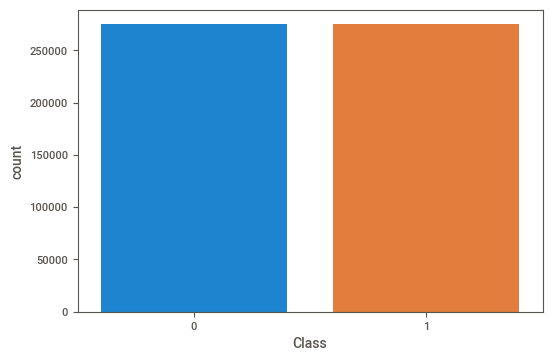

In [88]:
sns.countplot(y)

In [89]:
smoted = pd.concat([X,y], axis=1)
smoted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550380 entries, 0 to 550379
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V3      550380 non-null  float64
 1   V4      550380 non-null  float64
 2   V7      550380 non-null  float64
 3   V10     550380 non-null  float64
 4   V11     550380 non-null  float64
 5   V12     550380 non-null  float64
 6   V14     550380 non-null  float64
 7   V16     550380 non-null  float64
 8   V17     550380 non-null  float64
 9   Class   550380 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 42.0 MB


In [90]:
smoted.head()

,V3,V4,V7,V10,V11,V12,V14,V16,V17,Class
0,2.54,1.38,0.24,0.09,-0.55,-0.62,-0.31,-0.47,0.21,0
1,0.17,0.45,-0.08,-0.17,1.61,1.07,-0.14,0.46,-0.11,0
2,1.77,0.38,0.79,0.21,0.62,0.07,-0.17,-2.89,1.11,0
3,1.79,-0.86,0.24,-0.05,-0.23,0.18,-0.29,-1.06,-0.68,0
4,1.55,0.40,0.59,0.75,-0.82,0.54,-1.12,-0.45,-0.24,0


<AxesSubplot:xlabel='Class', ylabel='count'>

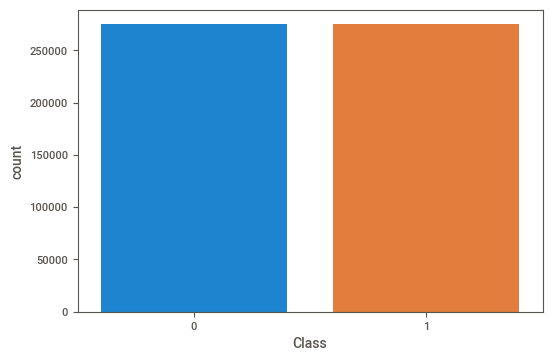

In [91]:
sns.countplot(smoted.Class)

## Experiment with Lazy Classifier
- on smoted df (smoted, df_samp)
- on original df (data, df_samp2)
- on slimmed df (df, df_samp3)

In [38]:
df_samp= smoted.sample(n=20000)

In [44]:
# X/y Split 
X = df_samp.loc[:, smoted.columns != 'Class']
y = df_samp['Class']
# Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print(f'Test Shape (X, y): {X_test.shape}, {y_test.shape}\nTrain shape (X, y): {X_train.shape}, {y_train.shape}')

Test Shape (X, y): (6000, 9), (6000,)
Train shape (X, y): (14000, 9), (14000,)


In [45]:
# fit all models
clf = LazyClassifier(predictions=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [00:22<00:00,  1.26it/s]


In [ ]:
models

In [51]:
df_samp2= data.sample(n=20000)
# X/y Split 
X = df_samp2.loc[:, data.columns != 'Class']
y = df_samp2['Class']
# Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print(f'Test Shape (X, y): {X_test.shape}, {y_test.shape}\nTrain shape (X, y): {X_train.shape}, {y_train.shape}')
# fit all models
clf = LazyClassifier(predictions=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

Test Shape (X, y): (6000, 30), (6000,)
Train shape (X, y): (14000, 30), (14000,)


100%|██████████| 29/29 [00:38<00:00,  1.33s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreeClassifier,1.00,1.00,1.00,1.00,0.06
Perceptron,1.00,1.00,1.00,1.00,0.08
GaussianNB,0.98,0.99,0.99,0.99,0.05
AdaBoostClassifier,1.00,0.94,0.94,1.00,3.87
XGBClassifier,1.00,0.94,0.94,1.00,4.84
BaggingClassifier,1.00,0.94,0.94,1.00,2.43
NearestCentroid,1.00,0.89,0.89,1.00,0.08
LinearDiscriminantAnalysis,1.00,0.89,0.89,1.00,0.12
KNeighborsClassifier,1.00,0.89,0.89,1.00,0.68


In [ ]:
df_samp3= df.sample(n=20000)
# X/y Split 
X = df_samp3.loc[:, df.columns != 'Class']
y = df_samp3['Class']
# Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print(f'Test Shape (X, y): {X_test.shape}, {y_test.shape}\nTrain shape (X, y): {X_train.shape}, {y_train.shape}')
# fit all models
clf = LazyClassifier(predictions=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

### Running lazy classifier on the 3 different versions we have of the data so far, we see that there are numerous models we could use that will give optimal accuracy.

Compared to out findings yesterday where ANN gave 97% I think ANN is the best bet.

One last version of the data is to adjust for outliers and duplicates (with AutoClean)

In [55]:
# initializing all the model objects with default parameters
model_1 = AdaBoostClassifier()
model_2 = XGBClassifier()
model_3 = ExtraTreesClassifier()

In [56]:
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)

ExtraTreesClassifier()

In [57]:
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)

In [58]:
MSE_1= mean_squared_error(y_test, pred_1)
MSE_2= mean_squared_error(y_test, pred_2)
MSE_3= mean_squared_error(y_test, pred_3)

accuracy_1=(1-mean_squared_error(y_test, pred_1))*100
accuracy_2=(1-mean_squared_error(y_test, pred_2))*100
accuracy_3=(1-mean_squared_error(y_test, pred_3))*100
print(f'For AdaBoost: MSE= {MSE_1}\nAccuracy(%)= {accuracy_1}\nFor XGB: MSE= {MSE_2}\nAccuracy(%)= {accuracy_2}\nFor ExtraTree: MSE= {MSE_3}\nAccuracy(%)= {accuracy_3}')

For AdaBoost: MSE= 0.0005
Accuracy(%)= 99.95
For XGB: MSE= 0.0005
Accuracy(%)= 99.95
For ExtraTree: MSE= 0.0003333333333333333
Accuracy(%)= 99.96666666666667


In [60]:
pred_1 = model_1.predict(X_train)
pred_2 = model_2.predict(X_train)
pred_3 = model_3.predict(X_train)

MSE_1= mean_squared_error(y_train, pred_1)
MSE_2= mean_squared_error(y_train, pred_2)
MSE_3= mean_squared_error(y_train, pred_3)

accuracy_1=(1-mean_squared_error(y_train, pred_1))*100
accuracy_2=(1-mean_squared_error(y_train, pred_2))*100
accuracy_3=(1-mean_squared_error(y_train, pred_3))*100
print(f'For AdaBoost: MSE= {MSE_1}\nAccuracy(%)= {accuracy_1}\nFor XGB: MSE= {MSE_2}\nAccuracy(%)= {accuracy_2}\nFor ExtraTree: MSE= {MSE_3}\nAccuracy(%)= {accuracy_3}')

For AdaBoost: MSE= 0.0
Accuracy(%)= 100.0
For XGB: MSE= 0.0
Accuracy(%)= 100.0
For ExtraTree: MSE= 0.0
Accuracy(%)= 100.0


In [93]:
clean_smote = AutoClean(smoted.sample(n=50000), mode='manual', outliers='auto', verbose=True)

14-03-2023 23:45:14.72 - INFO - Started validation of input parameters...
14-03-2023 23:45:14.72 - INFO - Completed validation of input parameters
14-03-2023 23:45:14.73 - INFO - Skipped handling of duplicates
14-03-2023 23:45:14.74 - INFO - Skipped handling of missing values
14-03-2023 23:45:14.74 - INFO - Started handling of outliers... Method: "AUTO"
14-03-2023 23:45:25.75 - DEBUG - Outlier imputation of 4069 value(s) succeeded for feature "V3"
14-03-2023 23:45:27.86 - DEBUG - Outlier imputation of 887 value(s) succeeded for feature "V4"
14-03-2023 23:45:42.47 - DEBUG - Outlier imputation of 6024 value(s) succeeded for feature "V7"
14-03-2023 23:45:52.81 - DEBUG - Outlier imputation of 4097 value(s) succeeded for feature "V10"
14-03-2023 23:45:55.47 - DEBUG - Outlier imputation of 1122 value(s) succeeded for feature "V11"
14-03-2023 23:46:01.87 - DEBUG - Outlier imputation of 2316 value(s) succeeded for feature "V12"
14-03-2023 23:46:02.81 - DEBUG - Outlier imputation of 384 value(s

Logfile saved to: /content/autoclean.log


### the df 'clean_smote' should be clean of outliers and duplicates as well as balanced.  

In [94]:
clean_smote=pd.DataFrame(clean_smote.output)

In [97]:
from pathlib import Path  
filepath = Path('/content/drive/MyDrive/Data Science/Data Science Data/Portfolio_Project/clean_smote_50000.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
clean_smote.to_csv(filepath)  

In [96]:
clean_smote.head()

,V3,V4,V7,V10,V11,V12,V14,V16,V17,Class
0,-5.64,1.96,-4.89,-5.17,2.14,-4.18,-3.10,-4.84,-8.06,1
1,-1.12,0.42,0.08,0.12,-1.06,-0.39,0.58,-0.02,-0.22,0
2,0.41,-2.50,-0.05,-1.53,-0.42,0.18,0.29,1.05,-1.13,0
3,-4.13,6.31,1.66,-1.80,1.88,-3.31,-2.56,-2.74,-4.29,1
4,0.84,0.86,0.32,-0.02,-1.85,-1.46,0.68,-0.86,0.51,0


<AxesSubplot:xlabel='Class', ylabel='count'>

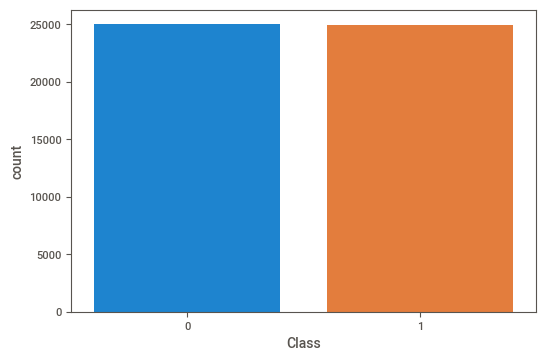

In [95]:
sns.countplot(clean_smote.Class)

In [3]:
clean_smote50000=pd.read_csv('/content/drive/MyDrive/Data Science/Data Science Data/Portfolio_Project/clean_smote_50000.csv')

In [5]:
df_samp4= clean_smote50000.sample(25000)
# X/y Split 
X = df_samp4.loc[:, df_samp4.columns != 'Class']
y = df_samp4['Class']
# Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print(f'Test Shape (X, y): {X_test.shape}, {y_test.shape}\nTrain shape (X, y): {X_train.shape}, {y_train.shape}')
# fit all models
clf = LazyClassifier(predictions=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

Test Shape (X, y): (7500, 10), (7500,)
Train shape (X, y): (17500, 10), (17500,)


100%|██████████| 29/29 [01:25<00:00,  2.94s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.99,0.99,0.99,0.99,1.16
XGBClassifier,0.99,0.99,0.99,0.99,3.37
LGBMClassifier,0.99,0.99,0.99,0.99,0.77
RandomForestClassifier,0.99,0.99,0.99,0.99,5.72
BaggingClassifier,0.98,0.98,0.98,0.98,1.95
LabelPropagation,0.98,0.98,0.98,0.98,15.44
LabelSpreading,0.97,0.97,0.97,0.97,24.28
DecisionTreeClassifier,0.97,0.97,0.97,0.97,0.30
KNeighborsClassifier,0.97,0.97,0.97,0.97,0.62


## Finally!!!

This is what we've been aiming for!

Due to the RAM limitation so free Colab I had to use a sample size of 25000.  But with the sample we achieved very nice accuracy results!

With this version of the data we will move to bk 3 where I will start with this LazyClassifier report, then I will run Logreg, extratree, and XGB as well as the ANN model from bk 1. I will then create visuals to compare the findings and that should be that!

🥲

In [6]:

lr1 = LogisticRegression()
lr1.fit(X_train, y_train)
predictions = lr1.predict(X_test)
  
# print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      3722
           1       0.97      0.90      0.93      3778

    accuracy                           0.94      7500
   macro avg       0.94      0.94      0.94      7500
weighted avg       0.94      0.94      0.94      7500



In [7]:
predictions = lr1.predict(X_train)
  
# print classification report
print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      8789
           1       0.97      0.90      0.93      8711

    accuracy                           0.94     17500
   macro avg       0.94      0.94      0.94     17500
weighted avg       0.94      0.94      0.94     17500



In [10]:
X_train.shape

(17500, 10)

In [19]:
def design_mlp():
    model = Sequential()
    model.add(Dense(150,input_shape =(None,17500, 10),activation="relu"))
    model.add(Dense(200,activation="tanh"))
    model.add(Dense(100,activation="tanh"))
    model.add(Dense(1000,activation="tanh"))
    model.add(Dense(1,activation="sigmoid"))
    model.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])
    return model

In [21]:
model = design_mlp()
model.fit(X_train, y_train,epochs=15, batch_size=15)

Epoch 1/15


1167/1167 [==============================] - 11s 6ms/step - loss: 0.7040 - accuracy: 0.4986
Epoch 2/15
1167/1167 [==============================] - 6s 5ms/step - loss: 0.6956 - accuracy: 0.4965
Epoch 3/15
1167/1167 [==============================] - 7s 6ms/step - loss: 0.6965 - accuracy: 0.5045
Epoch 4/15
1167/1167 [==============================] - 6s 5ms/step - loss: 0.6959 - accuracy: 0.4990
Epoch 5/15
1167/1167 [==============================] - 8s 7ms/step - loss: 0.6963 - accuracy: 0.5054
Epoch 6/15
1167/1167 [==============================] - 6s 5ms/step - loss: 0.6956 - accuracy: 0.5038
Epoch 7/15
1167/1167 [==============================] - 8s 7ms/step - loss: 0.6954 - accuracy: 0.4912
Epoch 8/15
1167/1167 [==============================] - 6s 5ms/step - loss: 0.6981 - accuracy: 0.5022
Epoch 9/15
1167/1167 [==============================] - 7s 6ms/step - loss: 0.6950 - accuracy: 0.5053
Epoch 10/15
1167/1167 [==============================] - 6s 5ms/step - loss: 0.6973 - accura

In [24]:
# Defining a function for finding best hyperparameters
def FunctionFindBestParams(X_train, y_train):
    
    # Defining the list of hyper parameters to try
    TrialNumber=0
    batch_size_list=[5, 10, 15, 20]
    epoch_list=[5, 10, 25 ,50]
    
    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])
    
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber+=1
            
            # Creating the classifier ANN model
            classifier = Sequential()
            classifier.add(Dense(units=10, input_dim=10, kernel_initializer='uniform', activation='relu'))
            classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu'))
            classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
            classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

            
            hyper_model=classifier.fit(X_train,y_train, batch_size=batch_size_trial , epochs=epochs_trial, verbose=0)
            # Fetching the accuracy of the training
            Accuracy = hyper_model.history['accuracy'][-1]
            
            # printing the results of the current iteration
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', Accuracy)
            
            SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber,
                            'batch_size'+str(batch_size_trial)+'-'+'epoch'+str(epochs_trial), Accuracy]],
                                                                    columns=['TrialNumber', 'Parameters', 'Accuracy'] ))
    return(SearchResultsData)

###############################################

# Calling the function
ResultsData=FunctionFindBestParams(X_train, y_train)

1 Parameters: batch_size: 5 - epochs: 5 Accuracy: 0.9045143127441406
2 Parameters: batch_size: 5 - epochs: 10 Accuracy: 0.9166285991668701
3 Parameters: batch_size: 5 - epochs: 25 Accuracy: 0.922171413898468
4 Parameters: batch_size: 5 - epochs: 50 Accuracy: 0.9266856908798218
5 Parameters: batch_size: 10 - epochs: 5 Accuracy: 0.9041714072227478
6 Parameters: batch_size: 10 - epochs: 10 Accuracy: 0.9181714057922363
7 Parameters: batch_size: 10 - epochs: 25 Accuracy: 0.9226285815238953
8 Parameters: batch_size: 10 - epochs: 50 Accuracy: 0.9242285490036011
9 Parameters: batch_size: 15 - epochs: 5 Accuracy: 0.9132571220397949
10 Parameters: batch_size: 15 - epochs: 10 Accuracy: 0.9164571166038513
11 Parameters: batch_size: 15 - epochs: 25 Accuracy: 0.9265714287757874
12 Parameters: batch_size: 15 - epochs: 50 Accuracy: 0.9298285841941833
13 Parameters: batch_size: 20 - epochs: 5 Accuracy: 0.8795999884605408
14 Parameters: batch_size: 20 - epochs: 10 Accuracy: 0.9029714465141296
15 Paramet